<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/FastText_BiLSTM-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet
!pip install gensim==3.8.3 --quiet
!pip install compress-fasttext==0.0.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 KB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 KB 19.8 MB/s eta 0:00:00


In [ ]:
import wget
import os
import sys
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import compress_fasttext
import gensim

# **Get cleaned dataset**

In [ ]:
PATH_CLEANED_DATASET = 'data_cleaned_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [ ]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
137712,какой по счёт,0
57026,обалденный я такой же цвет волос я очень нрави...,0
191252,а вот без творог просто яблоко яйцо мука вкусный,0
165539,у россия есть прививка от грипп есть от корона...,0
199605,закрыть пасть мразот ты мизинец он не стоить э...,1
5432,девочка за август по быть до или нет всё по ра...,0
53229,всё правильно сперва насрать надо потом бабка ...,0
240823,а что автобус быть как автобус для тот время к...,0
184791,ты выглядеть действительно потрясающе,0
3695,согласный полностью отгрести по полный очень с...,0


In [ ]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 75.5010886860397


max:  890
min:  0
mean:  11.992447716423932


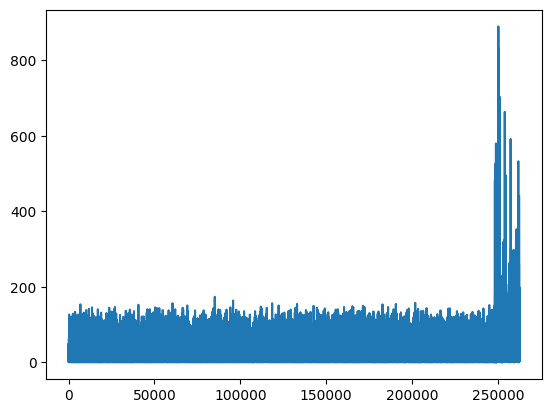

In [ ]:
print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [ ]:
sentences = df.comment.values
labels = df.toxic.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(210161,)
(210161,)
(26270,)
(26271,)


In [ ]:
# X_train=X_train[:10]
# y_train=y_train[:10]
# X_val=X_val[:10]
# y_val=y_val[:10]
# X_test=X_test[:10]
# y_test=y_test[:10]

In [ ]:
X_train.shape

(210161,)

[FastText Embedding by David Dale](https://github.com/avidale/compress-fasttext/releases/tag/v0.0.1)

In [ ]:
import compress_fasttext
# url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'

# print(small_model['спасибо'])
# # [ 0.26762889  0.35489027 ...  -0.06149674] # a 300-dimensional vector
# print(small_model.most_similar('котенок'))


# import fasttext
url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'
PATH_FASTTEXT = 'ft_freqprune_100K_20K_pq_300.bin'



if not os.path.exists(PATH_FASTTEXT):
    wget.download(url)
    
# ft = fasttext.load_model('ft_freqprune_100K_20K_pq_300.bin')

ft = gensim.models.fasttext.FastTextKeyedVectors.load('ft_freqprune_100K_20K_pq_300.bin')
print(ft['jhsfbjhsg'].shape)


(300,)


In [ ]:
PAD_TOKEN = '<pad>'

In [ ]:
def vectorize_sentence(sentence: str, vectorizer=ft, pad_token = PAD_TOKEN, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [vectorizer.get_vector(t) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [vectorizer[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [ ]:
sequence_length=64

# Word Vectorizer

In [ ]:
# X_train = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_train.flatten()
#     )
# ))

# X_val = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_val.flatten()
#     )
# ))

# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))

In [ ]:
X_train.shape

(210161,)

In [ ]:
ft[PAD_TOKEN].shape[0]

300

In [ ]:
DIMENSION_EMBEDDING=ft[PAD_TOKEN].shape[0]

# Build model  BiLSTM

Model: "FASTTEXT-RusVectores_CNN-GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (SpatialD  (None, 64, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64, 512)          1140736   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                      

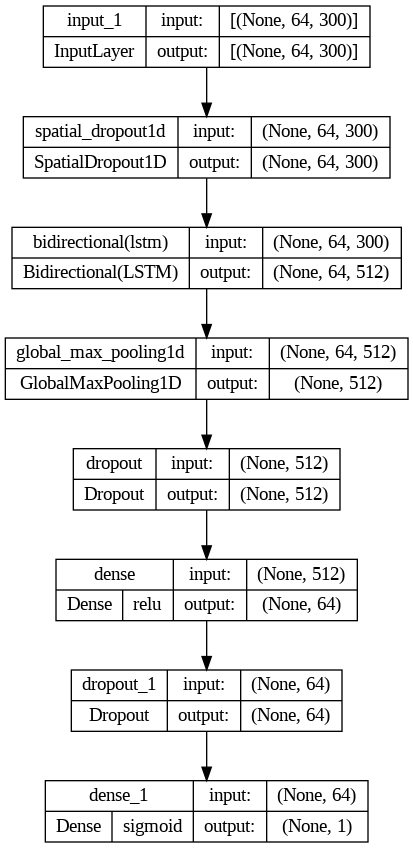

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,SpatialDropout1D,GlobalMaxPool1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
EPOCHS = 21
BATCH_SIZE = 512
MODEL_NAME = 'FASTTEXT-RusVectores_CNN-GRU'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [ ]:
X_test[:2]

array(['классный фигурка',
       'я уехать по семейный обстоятельство родитель быть пожилой они хотеться на родина дожить себя дом'],
      dtype=object)

In [ ]:
import math
class Dataset(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        ###################

        batch_x = np.array(list(map(
            lambda sentence:vectorize_sentence(
            sentence,
            vectorizer=ft,
            pad_token = PAD_TOKEN,
            max_sequence_length=sequence_length),
        batch_x.ravel()
        )
    ))

        ###################

        return batch_x, batch_y

In [ ]:
BATCH_SIZE

512

In [ ]:
train_gen = Dataset(x_set=X_train,y_set=y_train,batch_size=BATCH_SIZE)

val_gen = Dataset(x_set=X_val,y_set=y_val,batch_size=BATCH_SIZE)
x,y = train_gen.__getitem__(1)

In [ ]:
x.shape

(512, 64, 300)

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("GC")
        gc.collect()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val,y_val),
#     callbacks=[early_stopping],
#     class_weight=calculate_weights(neutral_count, negative_count),
# )

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping,GarbageCollectorCallback()],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/21
411/411 [==============================] - 463s 1s/step - loss: 0.3874 - tp: 31325.0000 - fp: 25269.0000 - tn: 145480.0000 - fn: 8087.0000 - accuracy: 0.8413 - precision: 0.5535 - recall: 0.7948 - auc: 0.9075 - prc: 0.7454 - val_loss: 0.2420 - val_tp: 4312.0000 - val_fp: 1907.0000 - val_tn: 19399.0000 - val_fn: 653.0000 - val_accuracy: 0.9026 - val_precision: 0.6934 - val_recall: 0.8685 - val_auc: 0.9574 - val_prc: 0.8793
Epoch 2/21
411/411 [==============================] - 445s 1s/step - loss: 0.2803 - tp: 34248.0000 - fp: 17495.0000 - tn: 153254.0000 - fn: 5164.0000 - accuracy: 0.8922 - precision: 0.6619 - recall: 0.8690 - auc: 0.9521 - prc: 0.8592 - val_loss: 0.2178 - val_tp: 4522.0000 - val_fp: 1801.0000 - val_tn: 19505.0000 - val_fn: 443.0000 - val_accuracy: 0.9146 - val_precision: 0.7152 - val_recall: 0.9108 - val_auc: 0.9713 - val_prc: 0.9166
Epoch 3/21
411/411 [==============================] - 447s 1s/step - loss: 0.2367 - tp: 35113.0000 - fp: 14398.0000 - tn: 1563

**Save Model**

In [ ]:
model.save(MODEL_NAME)

In [ ]:
X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))

In [ ]:
probs = model.predict(X_test).ravel()

821/821 [==============================] - 37s 43ms/step


In [ ]:
# threshold =0.5
# pred = np.where(probs<threshold,0,1)

**Model evaluation**

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 95.86 %
Recall: 91.04 %
Precision: 87.87 %
F1-score: 89.43 % 

precision: 0.9285938285520194, recall: 0.940218891999587, f1score: 0.9342573993249033
              precision    recall  f1-score   support

           0     0.9785    0.9701    0.9742     21216
           1     0.8787    0.9104    0.8943      5054

    accuracy                         0.9586     26270
   macro avg     0.9286    0.9402    0.9343     26270
weighted avg     0.9593    0.9586    0.9589     26270

True Negatives:  20581
False Positives:  635
False Negatives:  453
True Positives:  4601


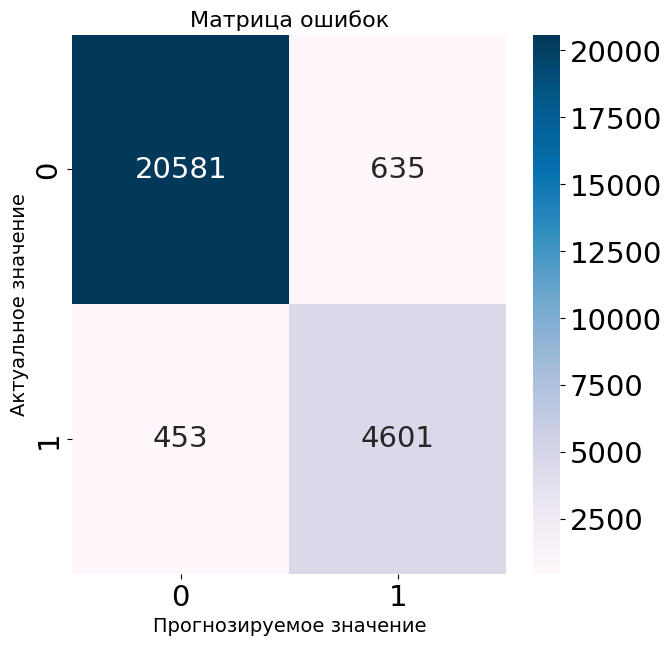

In [ ]:
plot_cm(y_test, probs)

In [ ]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

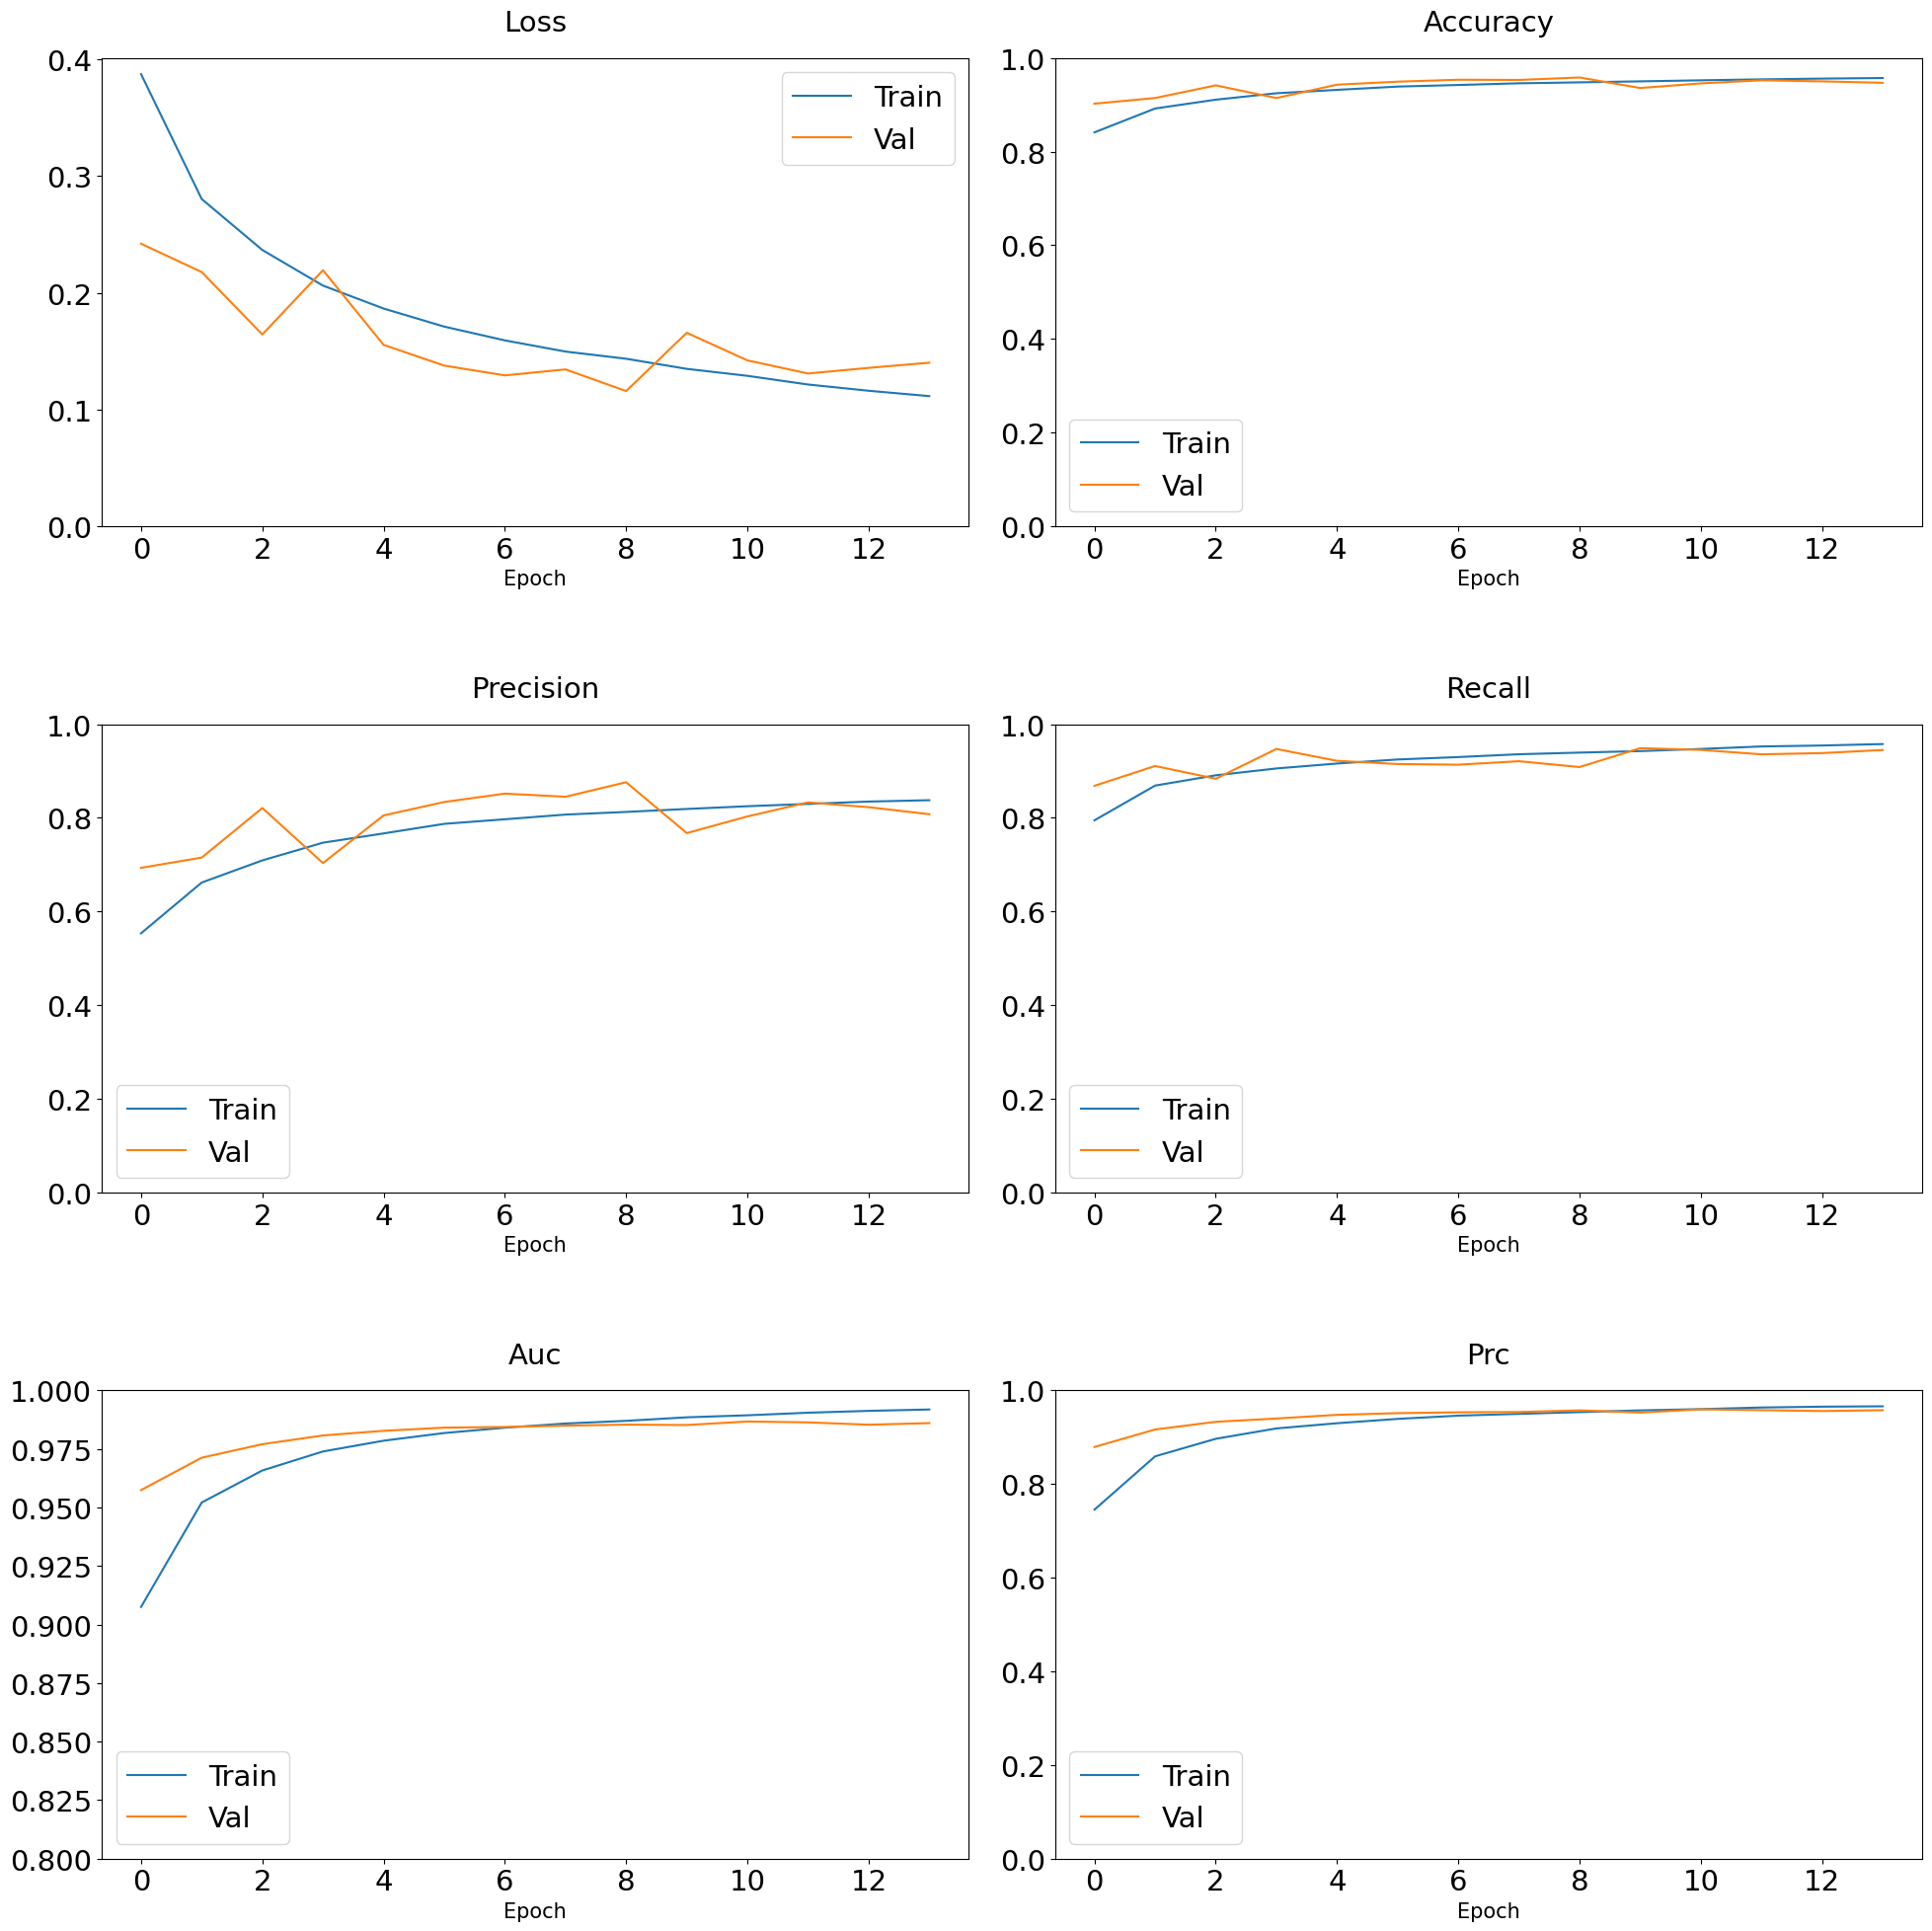

In [ ]:
plot_metrics(history)

**Show ROC - curve**

: ROC AUC=0.986
treshold
[1.9999999e+00 9.9999988e-01 9.9999928e-01 ... 1.1114844e-05 1.1097537e-05
 5.3767715e-09]


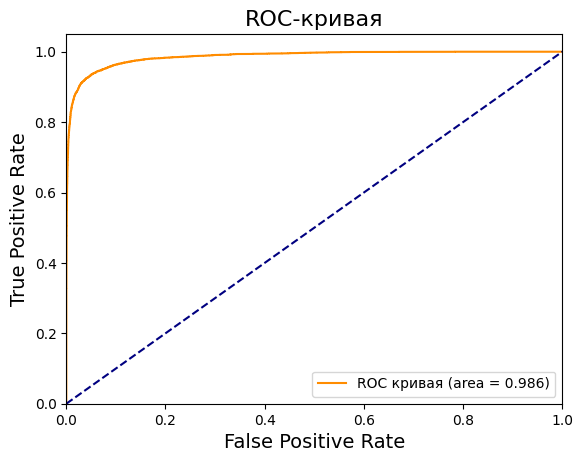

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = probs

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print('treshold')
print(treshold)

# размеры шрифта
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# строим график
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right",)
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, predictions_test)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]
print('Best F1-Score: ',max_f1)
print('Best threshold: ',max_f1_thresh)
plot_cm(y_test,predictions_test, p=max_f1_thresh)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [ ]:
antiInterr=777+0

In [ ]:
antiInterr=777+0